<img src=../images/gdms-vault.png width=1000 margin=0px>

---



# UC-4 App Role Authentication
---

## Business Value of Capability
 * Provide a way for operators to manage policy without being involved in generating tokens or creds for applications (minimize co-ordination) 
 * Operators have less work to do
 * Orchestration tools can take over the task of giving applications secrets access
 
### Prerequisites
* Running Vault Enterprise instance (even in dev mode)

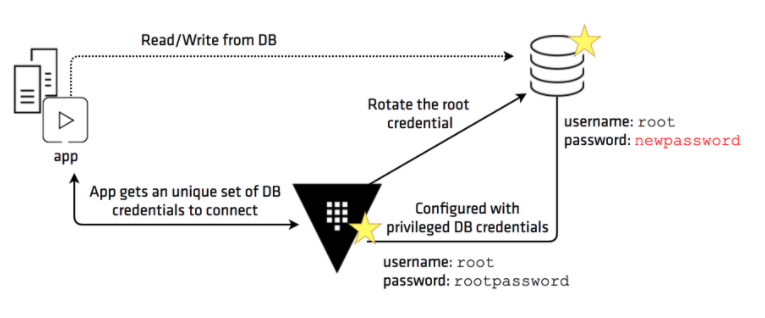

### Setup
---

In [1]:
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true

In [2]:
vault login root

WARNING! The VAULT_TOKEN environment variable is set! This takes precedence
over the value set by this command. To use the value set by this command,
unset the VAULT_TOKEN environment variable or set it to the token displayed
below.

Success! You are now authenticated. The token information displayed below
is already stored in the token helper. You do NOT need to run "vault login"
again. Future Vault requests will automatically use this token.

Key                  Value
---                  -----
token                root
token_accessor       OY25lT4bYKVe6lEurHCZGwJe
token_duration       ∞
token_renewable      false
token_policies       ["root"]
identity_policies    []
policies             ["root"]


In [3]:
vault status

Key             Value
---             -----
Seal Type       shamir
Initialized     true
Sealed          false
Total Shares    1
Threshold       1
Version         1.5.0+ent
Cluster Name    vault-cluster-e51522e6
Cluster ID      7cdabb51-34a6-fa3d-248e-bbb4f85b9857
HA Enabled      true
HA Cluster      https://127.0.0.1:8201
HA Mode         active
Last WAL        34


In [4]:
vault -version

Vault v1.5.0+ent


### Demo
---

**Create a new policy to govern this use case**  

In [5]:
echo '
path "auth/token/*" {
  capabilities = [ "create", "read", "update", "delete", "sudo" ]
}

# Manage secret/dev secret engine - for Verification test
path "secret/dev" {
  capabilities = [ "read" ]
}

# Manage secret/dev secret engine - for Verification test
path "secret/mysecret" {
  capabilities = [ "read" ]
}

path "auth/approle/role/application/role-id" {
  capabilities = ["read"]
}

path "auth/approle/role/application/secret-id" {
  capabilities = ["update"]
}

path "auth/approle/login" {
  capabilities = [ "create", "read"]
}

path "application/" {
  capabilities = ["list"]
}

path "application/*" {
  capabilities = ["list", "read"]
}' | vault policy write apps-policy -



Success! Uploaded policy: apps-policy


**Enable the approle authentication method**


In [6]:
vault auth enable approle

Success! Enabled approle auth method at: approle/


In [7]:
# Create a Secret (NOTE - num uses determines if you can reuse)
# wonder if Ancil put that in there to trip some of us up...hmmm
vault write auth/approle/role/myapp policies="apps-policy" secret_id_num_uses=5 secret_id_ttl=5m

Success! Data written to: auth/approle/role/myapp


In [8]:
# Readback
vault read auth/approle/role/myapp

Key                        Value
---                        -----
bind_secret_id             true
local_secret_ids           false
policies                   [apps-policy]
secret_id_bound_cidrs      <nil>
secret_id_num_uses         5
secret_id_ttl              5m
token_bound_cidrs          []
token_explicit_max_ttl     0s
token_max_ttl              0s
token_no_default_policy    false
token_num_uses             0
token_period               0s
token_policies             [apps-policy]
token_ttl                  0s
token_type                 default


**Get a role id (this is usually NOT changing - pass this to developer of app)**  

In [9]:
vault read auth/approle/role/myapp/role-id

Key        Value
---        -----
role_id    88cc7290-920e-eafd-a16c-972f18c043ce


**Attempt to read the role id using the API**. 


In [11]:
export APPROLE="myapp"
ROLE_ID=$(curl -H "X-Vault-Token: ${VAULT_TOKEN}" "http://127.0.0.1:8200/v1/auth/approle/role/${APPROLE}/role-id" | jq -r '.data.role_id')
echo $ROLE_ID

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   208  100   208    0     0   203k      0 --:--:-- --:--:-- --:--:--  203k
88cc7290-920e-eafd-a16c-972f18c043ce


**Generate a Secret ID**  

In [12]:
vault write -f auth/approle/role/myapp/secret-id

Key                   Value
---                   -----
secret_id             b826c26d-8ed0-bfde-9b19-cbd6c3e844a3
secret_id_accessor    0be7522e-98df-3bc9-fc2e-c1cb3eae06ab


**Generate a Secret ID using CURL instead**  

In [13]:
SECRET_ID=$(curl -X POST -H "X-Vault-Token:${VAULT_TOKEN}" "http://127.0.0.1:8200/v1/auth/approle/role/${APPROLE}/secret-id" | jq -r '.data.secret_id')
echo ${SECRET_ID}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   270  100   270    0     0   263k      0 --:--:-- --:--:-- --:--:--  263k
86c66968-fbe1-4ecc-91d5-d80e7f962528


**Write a new login with role id and secret id from to get the token for logging into vault**  

In [14]:
vault write auth/approle/login role_id=${ROLE_ID} \
  secret_id=${SECRET_ID}


Key                     Value
---                     -----
token                   s.PqHiqdafcE6OBuY8lYibwGn7
token_accessor          Fpfd8j1gcn98kzfMDKIPPpH2
token_duration          768h
token_renewable         true
token_policies          ["apps-policy" "default"]
identity_policies       []
policies                ["apps-policy" "default"]
token_meta_role_name    myapp


**Again, we can do the same using CURL**

In [15]:
APP_ROLE_TOKEN=$(curl -X POST -d '{"role_id": "'"${ROLE_ID}"'", "secret_id": "'"${SECRET_ID}"'"}' http://127.0.0.1:8200/v1/auth/approle/login | jq -r '.auth.client_token')
echo ${APP_ROLE_TOKEN}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   588  100   484  100   104   236k  52000 --:--:-- --:--:-- --:--:--  287k
s.PrXvanY5wDb8p1mGgpBkgrR2


In [17]:
vault login ${APP_ROLE_TOKEN}

WARNING! The VAULT_TOKEN environment variable is set! This takes precedence
over the value set by this command. To use the value set by this command,
unset the VAULT_TOKEN environment variable or set it to the token displayed
below.

Success! You are now authenticated. The token information displayed below
is already stored in the token helper. You do NOT need to run "vault login"
again. Future Vault requests will automatically use this token.

Key                     Value
---                     -----
token                   s.PrXvanY5wDb8p1mGgpBkgrR2
token_accessor          JcCvDSJ4SXLdoouECcTlDVAa
token_duration          767h57m8s
token_renewable         true
token_policies          ["apps-policy" "default"]
identity_policies       []
policies                ["apps-policy" "default"]
token_meta_role_name    myapp


**Demonstrate login to UI using the AppRole Token**

**END**